## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [3]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [19]:
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
## 超參數設定
"""
Set your hyper-parameters
"""

LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [20]:
results = {}
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Instructions for updati

50000/50000 [==============================] - 21s 415us/step - loss: 2.4626 - acc: 0.0965 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 20s 397us/step - loss: 2.4626 - acc: 0.0998 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 20s 396us/step - loss: 2.4626 - acc: 0.0972 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 20s 396us/step - loss: 2.4626 - acc: 0.0980 - val_loss: 2.4626 - val_acc: 0.1000
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dens

50000/50000 [==============================] - 20s 409us/step - loss: 2.7459 - acc: 0.6230 - val_loss: 3.0057 - val_acc: 0.5270
Epoch 48/50
50000/50000 [==============================] - 20s 409us/step - loss: 2.7122 - acc: 0.6253 - val_loss: 2.9286 - val_acc: 0.5381
Epoch 49/50
50000/50000 [==============================] - 20s 409us/step - loss: 2.6732 - acc: 0.6255 - val_loss: 2.9278 - val_acc: 0.5333- loss: 2.6729 - - ETA: 1s - loss: 2
Epoch 50/50
50000/50000 [==============================] - 20s 410us/step - loss: 2.6385 - acc: 0.6270 - val_loss: 2.8810 - val_acc: 0.5338
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________

50000/50000 [==============================] - 20s 409us/step - loss: 0.9252 - acc: 0.6746 - val_loss: 1.4112 - val_acc: 0.5235
Epoch 48/50
50000/50000 [==============================] - 21s 416us/step - loss: 0.9181 - acc: 0.6762 - val_loss: 1.4380 - val_acc: 0.5180
Epoch 49/50
50000/50000 [==============================] - 21s 426us/step - loss: 0.9038 - acc: 0.6818 - val_loss: 1.3825 - val_acc: 0.5306
Epoch 50/50
50000/50000 [==============================] - 21s 426us/step - loss: 0.8922 - acc: 0.6851 - val_loss: 1.4618 - val_acc: 0.5189
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dens

50000/50000 [==============================] - 19s 378us/step - loss: 0.9229 - acc: 0.6770 - val_loss: 1.4042 - val_acc: 0.5247
Epoch 48/50
50000/50000 [==============================] - 21s 418us/step - loss: 0.9122 - acc: 0.6819 - val_loss: 1.3865 - val_acc: 0.5298
Epoch 49/50
50000/50000 [==============================] - 19s 374us/step - loss: 0.8989 - acc: 0.6851 - val_loss: 1.4074 - val_acc: 0.5260
Epoch 50/50
50000/50000 [==============================] - 19s 378us/step - loss: 0.8890 - acc: 0.6892 - val_loss: 1.3794 - val_acc: 0.5345


In [24]:
import itertools
for l1, l2 in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1, l2))
    model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l1_ratio=l1, l2_ratio=l2)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1), str(l2))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 22s 432us/step - loss: 198.5948 - acc: 0.2275 - val_loss: 41.0514 - val_acc: 0.2537
Epoch 2/50
50000/50000 [==============================] - 21s 414us/step - loss: 19.0658 - acc: 0.1179 - val_loss: 7.2563 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 21s 415us/step - loss: 4.1031 - acc: 0.0987 - val_loss: 2.6449 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 21s 418us/step - loss: 2.4855 - acc: 0.0980 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 21s 417us/step - loss: 2.4626 - acc: 0.0990 - val_loss: 2.4628 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 21s 418us/step - loss: 2.4626 - acc: 0.0981 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 21s 417us/step - loss: 2.4626 - acc: 0.0969 - val_loss

50000/50000 [==============================] - 22s 449us/step - loss: 198.4270 - acc: 0.2304 - val_loss: 41.0447 - val_acc: 0.2543
Epoch 2/50
50000/50000 [==============================] - 22s 430us/step - loss: 19.0969 - acc: 0.1159 - val_loss: 7.2913 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 22s 431us/step - loss: 4.1182 - acc: 0.0995 - val_loss: 2.6499 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 22s 435us/step - loss: 2.4865 - acc: 0.0983 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 22s 433us/step - loss: 2.4626 - acc: 0.0988 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 22s 431us/step - loss: 2.4626 - acc: 0.0974 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 22s 433us/step - loss: 2.4626 - acc: 0.0981 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==========

Epoch 2/50
50000/50000 [==============================] - 21s 421us/step - loss: 18.9808 - acc: 0.1167 - val_loss: 7.2055 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 21s 425us/step - loss: 4.0794 - acc: 0.1000 - val_loss: 2.6461 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 21s 424us/step - loss: 2.4857 - acc: 0.0987 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 21s 430us/step - loss: 2.4626 - acc: 0.0988 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 21s 426us/step - loss: 2.4626 - acc: 0.0977 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 21s 426us/step - loss: 2.4626 - acc: 0.0974 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 21s 423us/step - loss: 2.4626 - acc: 0.0972 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==

Epoch 3/50
50000/50000 [==============================] - 21s 423us/step - loss: 13.9763 - acc: 0.3816 - val_loss: 12.9895 - val_acc: 0.3956
Epoch 4/50
50000/50000 [==============================] - 21s 420us/step - loss: 12.1247 - acc: 0.3948 - val_loss: 11.2920 - val_acc: 0.3952
Epoch 5/50
50000/50000 [==============================] - 21s 418us/step - loss: 10.5505 - acc: 0.4048 - val_loss: 9.8385 - val_acc: 0.4099
Epoch 6/50
50000/50000 [==============================] - 21s 420us/step - loss: 9.2110 - acc: 0.4120 - val_loss: 8.6019 - val_acc: 0.4159
Epoch 7/50
50000/50000 [==============================] - 21s 421us/step - loss: 8.0696 - acc: 0.4167 - val_loss: 7.5550 - val_acc: 0.4153
Epoch 8/50
50000/50000 [==============================] - 22s 442us/step - loss: 7.0975 - acc: 0.4208 - val_loss: 6.6632 - val_acc: 0.4166
Epoch 9/50
50000/50000 [==============================] - 22s 445us/step - loss: 6.2689 - acc: 0.4257 - val_loss: 5.8898 - val_acc: 0.4262
Epoch 10/50
50000/5000

50000/50000 [==============================] - 18s 355us/step - loss: 5.6879 - acc: 0.3974 - val_loss: 5.6228 - val_acc: 0.4091
Epoch 4/50
50000/50000 [==============================] - 17s 333us/step - loss: 5.5601 - acc: 0.4192 - val_loss: 5.5051 - val_acc: 0.4282
Epoch 5/50
50000/50000 [==============================] - 25s 507us/step - loss: 5.4471 - acc: 0.4339 - val_loss: 5.4061 - val_acc: 0.4333
Epoch 6/50
50000/50000 [==============================] - 29s 575us/step - loss: 5.3418 - acc: 0.4472 - val_loss: 5.3088 - val_acc: 0.4469
Epoch 7/50
50000/50000 [==============================] - 24s 475us/step - loss: 5.2443 - acc: 0.4572 - val_loss: 5.2237 - val_acc: 0.4515
Epoch 8/50
50000/50000 [==============================] - 18s 356us/step - loss: 5.1507 - acc: 0.4658 - val_loss: 5.1233 - val_acc: 0.4650
Epoch 9/50
50000/50000 [==============================] - 20s 406us/step - loss: 5.0599 - acc: 0.4757 - val_loss: 5.0656 - val_acc: 0.4605
Epoch 10/50
50000/50000 [=============

50000/50000 [==============================] - 17s 345us/step - loss: 5.5691 - acc: 0.3936 - val_loss: 5.4994 - val_acc: 0.4069
Epoch 4/50
50000/50000 [==============================] - 17s 335us/step - loss: 5.4486 - acc: 0.4143 - val_loss: 5.3973 - val_acc: 0.4258
Epoch 5/50
50000/50000 [==============================] - 23s 452us/step - loss: 5.3403 - acc: 0.4312 - val_loss: 5.2991 - val_acc: 0.4339
Epoch 6/50
50000/50000 [==============================] - 29s 575us/step - loss: 5.2386 - acc: 0.4455 - val_loss: 5.2071 - val_acc: 0.4417
Epoch 7/50
50000/50000 [==============================] - 25s 505us/step - loss: 5.1456 - acc: 0.4569 - val_loss: 5.1119 - val_acc: 0.4514
Epoch 8/50
50000/50000 [==============================] - 17s 339us/step - loss: 5.0547 - acc: 0.4680 - val_loss: 5.0389 - val_acc: 0.4546
Epoch 9/50
50000/50000 [==============================] - 17s 340us/step - loss: 4.9686 - acc: 0.4738 - val_loss: 4.9554 - val_acc: 0.4655
Epoch 10/50
50000/50000 [=============

Epoch 4/50
50000/50000 [==============================] - 17s 335us/step - loss: 5.4615 - acc: 0.4123 - val_loss: 5.4083 - val_acc: 0.4224
Epoch 5/50
50000/50000 [==============================] - 18s 362us/step - loss: 5.3519 - acc: 0.4274 - val_loss: 5.3077 - val_acc: 0.4302
Epoch 6/50
50000/50000 [==============================] - 38s 767us/step - loss: 5.2502 - acc: 0.4412 - val_loss: 5.2100 - val_acc: 0.4459
Epoch 7/50
50000/50000 [==============================] - 30s 593us/step - loss: 5.1547 - acc: 0.4545 - val_loss: 5.1205 - val_acc: 0.4555
Epoch 8/50
50000/50000 [==============================] - 19s 387us/step - loss: 5.0651 - acc: 0.4637 - val_loss: 5.0460 - val_acc: 0.4588
Epoch 9/50
50000/50000 [==============================] - 18s 352us/step - loss: 4.9787 - acc: 0.4727 - val_loss: 4.9560 - val_acc: 0.4654
Epoch 10/50
50000/50000 [==============================] - 19s 380us/step - loss: 4.8944 - acc: 0.4823 - val_loss: 4.8849 - val_acc: 0.4664
Epoch 11/50
50000/50000 [=

Epoch 5/50
50000/50000 [==============================] - 30s 593us/step - loss: 8.7232 - acc: 0.4113 - val_loss: 8.1759 - val_acc: 0.4148
Epoch 6/50
50000/50000 [==============================] - 20s 409us/step - loss: 7.7011 - acc: 0.4191 - val_loss: 7.2344 - val_acc: 0.4250
Epoch 7/50
50000/50000 [==============================] - 17s 347us/step - loss: 6.8285 - acc: 0.4260 - val_loss: 6.4298 - val_acc: 0.4391
Epoch 8/50
50000/50000 [==============================] - 18s 364us/step - loss: 6.0848 - acc: 0.4317 - val_loss: 5.7455 - val_acc: 0.4424
Epoch 9/50
50000/50000 [==============================] - 27s 546us/step - loss: 5.4493 - acc: 0.4367 - val_loss: 5.1623 - val_acc: 0.4435
Epoch 10/50
50000/50000 [==============================] - 30s 594us/step - loss: 4.9064 - acc: 0.4441 - val_loss: 4.6675 - val_acc: 0.4407
Epoch 11/50
50000/50000 [==============================] - 21s 414us/step - loss: 4.4422 - acc: 0.4475 - val_loss: 4.2495 - val_acc: 0.4373
Epoch 12/50
50000/50000 [

50000/50000 [==============================] - 18s 356us/step - loss: 1.7719 - acc: 0.4300 - val_loss: 1.7529 - val_acc: 0.4355
Epoch 6/50
50000/50000 [==============================] - 17s 348us/step - loss: 1.7311 - acc: 0.4412 - val_loss: 1.7285 - val_acc: 0.4467
Epoch 7/50
50000/50000 [==============================] - 24s 472us/step - loss: 1.6968 - acc: 0.4555 - val_loss: 1.6980 - val_acc: 0.4479
Epoch 8/50
50000/50000 [==============================] - 32s 643us/step - loss: 1.6660 - acc: 0.4652 - val_loss: 1.6796 - val_acc: 0.4564
Epoch 9/50
50000/50000 [==============================] - 26s 512us/step - loss: 1.6375 - acc: 0.4761 - val_loss: 1.6472 - val_acc: 0.4672
Epoch 10/50
50000/50000 [==============================] - 19s 384us/step - loss: 1.6111 - acc: 0.4842 - val_loss: 1.6313 - val_acc: 0.4720
Epoch 11/50
50000/50000 [==============================] - 21s 420us/step - loss: 1.5872 - acc: 0.4921 - val_loss: 1.6150 - val_acc: 0.4767
Epoch 12/50
50000/50000 [===========

50000/50000 [==============================] - 21s 415us/step - loss: 1.6098 - acc: 0.4362 - val_loss: 1.6001 - val_acc: 0.4417
Epoch 6/50
50000/50000 [==============================] - 29s 588us/step - loss: 1.5723 - acc: 0.4468 - val_loss: 1.5670 - val_acc: 0.4502
Epoch 7/50
50000/50000 [==============================] - 24s 472us/step - loss: 1.5404 - acc: 0.4591 - val_loss: 1.5488 - val_acc: 0.4503
Epoch 8/50
50000/50000 [==============================] - 17s 343us/step - loss: 1.5093 - acc: 0.4703 - val_loss: 1.5223 - val_acc: 0.4614
Epoch 9/50
50000/50000 [==============================] - 17s 345us/step - loss: 1.4825 - acc: 0.4796 - val_loss: 1.5089 - val_acc: 0.4629
Epoch 10/50
50000/50000 [==============================] - 20s 399us/step - loss: 1.4581 - acc: 0.4879 - val_loss: 1.4905 - val_acc: 0.4723
Epoch 11/50
50000/50000 [==============================] - 29s 581us/step - loss: 1.4349 - acc: 0.4978 - val_loss: 1.4885 - val_acc: 0.4659
Epoch 12/50
50000/50000 [===========

Epoch 6/50
50000/50000 [==============================] - 25s 501us/step - loss: 1.5608 - acc: 0.4532 - val_loss: 1.5572 - val_acc: 0.4513
Epoch 7/50
50000/50000 [==============================] - 29s 588us/step - loss: 1.5272 - acc: 0.4650 - val_loss: 1.5359 - val_acc: 0.4580
Epoch 8/50
50000/50000 [==============================] - 20s 409us/step - loss: 1.4968 - acc: 0.4760 - val_loss: 1.5125 - val_acc: 0.4665
Epoch 9/50
50000/50000 [==============================] - 17s 348us/step - loss: 1.4714 - acc: 0.4825 - val_loss: 1.4979 - val_acc: 0.4680
Epoch 10/50
50000/50000 [==============================] - 18s 360us/step - loss: 1.4461 - acc: 0.4927 - val_loss: 1.4770 - val_acc: 0.4754
Epoch 11/50
50000/50000 [==============================] - 27s 541us/step - loss: 1.4224 - acc: 0.5016 - val_loss: 1.4652 - val_acc: 0.4793
Epoch 12/50
50000/50000 [==============================] - 29s 582us/step - loss: 1.4009 - acc: 0.5081 - val_loss: 1.4467 - val_acc: 0.4852
Epoch 13/50
50000/50000 

Epoch 7/50
50000/50000 [==============================] - 29s 583us/step - loss: 6.8436 - acc: 0.4203 - val_loss: 6.4489 - val_acc: 0.4264
Epoch 8/50
50000/50000 [==============================] - 24s 477us/step - loss: 6.0982 - acc: 0.4272 - val_loss: 5.7669 - val_acc: 0.4270 2s - loss: 6.1412 - acc:  - ETA: 2s - loss: 6
Epoch 9/50
50000/50000 [==============================] - 17s 343us/step - loss: 5.4620 - acc: 0.4328 - val_loss: 5.1805 - val_acc: 0.4274
Epoch 10/50
50000/50000 [==============================] - 17s 349us/step - loss: 4.9173 - acc: 0.4390 - val_loss: 4.6713 - val_acc: 0.4397
Epoch 11/50
50000/50000 [==============================] - 25s 503us/step - loss: 4.4521 - acc: 0.4421 - val_loss: 4.2619 - val_acc: 0.4309
Epoch 12/50
50000/50000 [==============================] - 29s 586us/step - loss: 4.0547 - acc: 0.4446 - val_loss: 3.8781 - val_acc: 0.4453
Epoch 13/50
50000/50000 [==============================] - 24s 484us/step - loss: 3.7140 - acc: 0.4494 - val_loss: 3.

50000/50000 [==============================] - 18s 365us/step - loss: 1.6781 - acc: 0.4610 - val_loss: 1.6915 - val_acc: 0.4526
Epoch 8/50
50000/50000 [==============================] - 18s 354us/step - loss: 1.6456 - acc: 0.4708 - val_loss: 1.6582 - val_acc: 0.4652
Epoch 9/50
50000/50000 [==============================] - 24s 488us/step - loss: 1.6183 - acc: 0.4808 - val_loss: 1.6425 - val_acc: 0.4663
Epoch 10/50
50000/50000 [==============================] - 30s 607us/step - loss: 1.5946 - acc: 0.4891 - val_loss: 1.6115 - val_acc: 0.4767
Epoch 11/50
50000/50000 [==============================] - 26s 524us/step - loss: 1.5698 - acc: 0.4987 - val_loss: 1.6022 - val_acc: 0.4809
Epoch 12/50
50000/50000 [==============================] - 18s 359us/step - loss: 1.5488 - acc: 0.5054 - val_loss: 1.5872 - val_acc: 0.4883
Epoch 13/50
50000/50000 [==============================] - 18s 355us/step - loss: 1.5261 - acc: 0.5104 - val_loss: 1.5695 - val_acc: 0.4865
Epoch 14/50
50000/50000 [=========

50000/50000 [==============================] - 19s 372us/step - loss: 1.5289 - acc: 0.4633 - val_loss: 1.5471 - val_acc: 0.4533
Epoch 8/50
50000/50000 [==============================] - 27s 544us/step - loss: 1.5012 - acc: 0.4717 - val_loss: 1.5111 - val_acc: 0.4656
Epoch 9/50
50000/50000 [==============================] - 34s 680us/step - loss: 1.4743 - acc: 0.4845 - val_loss: 1.4883 - val_acc: 0.4732
Epoch 10/50
50000/50000 [==============================] - 22s 439us/step - loss: 1.4490 - acc: 0.4926 - val_loss: 1.4703 - val_acc: 0.4786
Epoch 11/50
50000/50000 [==============================] - 18s 351us/step - loss: 1.4259 - acc: 0.4992 - val_loss: 1.4633 - val_acc: 0.4791
Epoch 12/50
50000/50000 [==============================] - 19s 380us/step - loss: 1.4041 - acc: 0.5067 - val_loss: 1.4534 - val_acc: 0.4795
Epoch 13/50
50000/50000 [==============================] - 28s 565us/step - loss: 1.3835 - acc: 0.5151 - val_loss: 1.4392 - val_acc: 0.4927
Epoch 14/50
50000/50000 [=========

50000/50000 [==============================] - 19s 376us/step - loss: 1.5401 - acc: 0.4597 - val_loss: 1.5563 - val_acc: 0.4483
Epoch 8/50
50000/50000 [==============================] - 28s 558us/step - loss: 1.5119 - acc: 0.4706 - val_loss: 1.5142 - val_acc: 0.4598
Epoch 9/50
50000/50000 [==============================] - 29s 581us/step - loss: 1.4830 - acc: 0.4807 - val_loss: 1.4961 - val_acc: 0.4644
Epoch 10/50
50000/50000 [==============================] - 21s 422us/step - loss: 1.4571 - acc: 0.4895 - val_loss: 1.4981 - val_acc: 0.4680
Epoch 11/50
50000/50000 [==============================] - 21s 425us/step - loss: 1.4333 - acc: 0.4979 - val_loss: 1.4612 - val_acc: 0.4807
Epoch 12/50
50000/50000 [==============================] - 19s 381us/step - loss: 1.4104 - acc: 0.5056 - val_loss: 1.4527 - val_acc: 0.4895
Epoch 13/50
50000/50000 [==============================] - 29s 576us/step - loss: 1.3914 - acc: 0.5111 - val_loss: 1.4359 - val_acc: 0.4897
Epoch 14/50
50000/50000 [=========

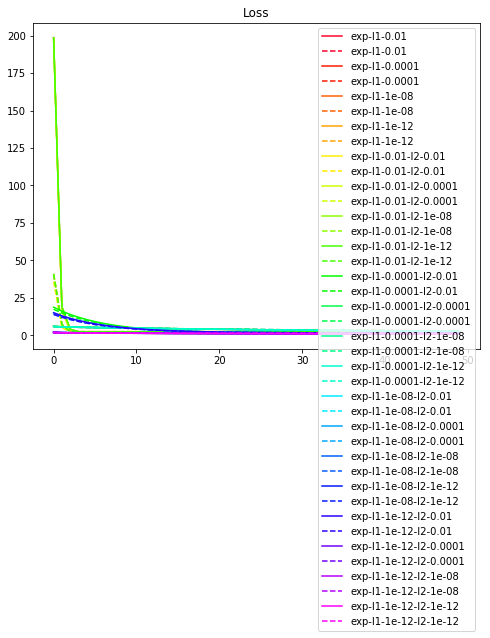

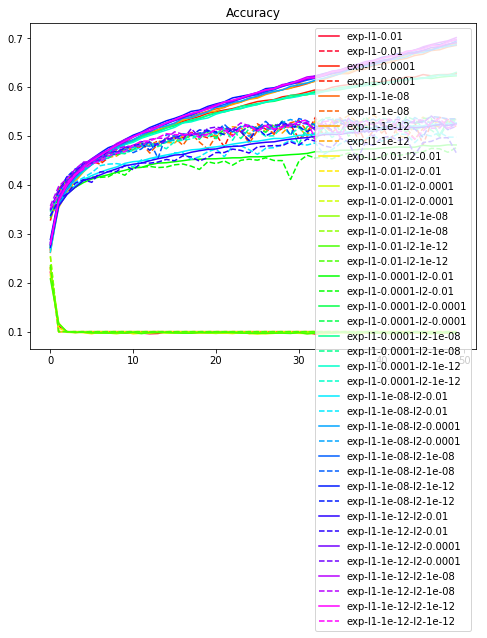

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
將實驗結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()